In [1]:
!pip install pytorch_lightning
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyl

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import Autoformer
from neuralforecast.losses.pytorch import MAE
from google.colab import files
uploaded = files.upload()

Saving halong_quality.csv to halong_quality.csv


In [9]:
data = pd.read_csv('halong_quality.csv')

# Thay thế cột 'date' bằng chỉ số từ 0 đến N-1
data['index'] = np.arange(len(data))

# Chuẩn bị dữ liệu cho mô hình
data['unique_id'] = 'pm25'
data['y'] = data['pm25']
data['ds'] = data['index']

def smoothed(data):
    # Áp dụng bộ lọc trung bình động để làm mượt các giá trị dự báo
    window_size = 5
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Nội suy các giá trị NaN kết quả từ trung bình động
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Điền các giá trị NaN còn lại
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # hoặc 'ffill', hoặc dùng fillna(value=0)

    return forecast_smoothed_filled

# Làm mượt dữ liệu
data['y_smooth'] = smoothed(data['y'])

# Chia dữ liệu thành train và test theo tỉ lệ 8:2
split_idx = int(len(data) * 0.8)
train_data = data[:split_idx].copy()
test_data = data[split_idx:].copy()

# Chỉ giữ lại các cột cần thiết
train_data = train_data[['unique_id', 'ds', 'y_smooth']].rename(columns={'y_smooth': 'y'})
test_data = test_data[['unique_id', 'ds', 'y_smooth']].rename(columns={'y_smooth': 'y'})

In [10]:
# Khởi tạo và huấn luyện mô hình
import torch
model = Autoformer(
    h=len(test_data),  # forecast horizon
    input_size=30,  # maximum sequence length
    hidden_size=16,  # units of embeddings and encoders
    conv_hidden_size=32,  # channels of the convolutional encoder
    n_head=1,  # number of multi-head's attention
    loss=MAE(),  # loss function
    futr_exog_list=[],  # no future exogenous columns
    scaler_type='robust',  # type of scaler for temporal inputs normalization
    learning_rate=1e-3,  # learning rate
    max_steps=100,  # maximum number of training steps
    optimizer=torch.optim.Adam  # optimizer
)

nf = NeuralForecast(
    models=[model],
    freq=1  # tần suất của dữ liệu chuỗi thời gian
)

nf.fit(df=train_data)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 48     | train
5 | dec_embedding | DataEmbedding | 48     | train
6 | encoder       | Encoder       | 4.3 K  | train
7 | decoder       | Decoder       | 3.3 K  | train
--------------------------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.031  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [11]:
# Dự đoán trên tập test
forecasts = nf.predict(futr_df=test_data)
predictions = forecasts['Autoformer'].values

# Smooth the predictions
predictions_smoothed = smoothed(pd.Series(predictions)).values

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [12]:
# Đánh giá mô hình
y_true = test_data['y'].values
y_pred = predictions_smoothed

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 13.138556807521976
MAE: 10.256940253575642
MAPE: 32.433815453457534


In [13]:
model = Autoformer(
    h=90,  # forecast horizon
    input_size=30,  # maximum sequence length (Sử dụng 30 bước thời gian trước đó làm đầu vào.)
    hidden_size=16,  # units of embeddings and encoders
    conv_hidden_size=32,  # channels of the convolutional encoder
    n_head=1,  # number of multi-head's attention
    loss=MAE(),  # loss function
    futr_exog_list=[],  # no future exogenous columns
    scaler_type='robust',  # type of scaler for temporal inputs normalization
    learning_rate=1e-3,  # learning rate
    max_steps=100,  # maximum number of training steps
    optimizer=torch.optim.Adam  # optimizer
)

nf = NeuralForecast(
    models=[model],
    freq=1  # tần suất của dữ liệu chuỗi thời gian
)

# Chỉ giữ lại các cột cần thiết
data = data[['unique_id', 'ds', 'y']]

nf.fit(df=data)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 48     | train
5 | dec_embedding | DataEmbedding | 48     | train
6 | encoder       | Encoder       | 4.3 K  | train
7 | decoder       | Decoder       | 3.3 K  | train
--------------------------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.031  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


In [14]:
future_data = pd.DataFrame({
    'unique_id': ['pm25'] * 90,
    'ds': np.arange(len(data), len(data) + 90),
    'y': [np.nan] * 90
})

# Dự báo 90 ngày tiếp theo
forecasts = nf.predict(futr_df=future_data)
future_predictions = forecasts['Autoformer'].values

# Tách dữ liệu dự đoán thành 3 phần
future_predictions_1_30 = future_predictions[:30]
future_predictions_31_60 = future_predictions[30:60]
future_predictions_61_90 = future_predictions[60:]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [15]:
# In ra các dự đoán
print("90D Predictions:")
print(future_predictions)

90D Predictions:
[38.52185  39.836372 39.04378  40.438206 42.16631  42.685387 43.253834
 42.197674 46.242516 45.350204 44.13629  45.65655  41.99252  44.785767
 44.43906  42.33545  42.41239  43.559303 42.47518  44.065235 41.78693
 42.736496 44.655106 43.612816 42.571663 44.147675 43.552067 44.078056
 44.218704 43.09161  42.99173  43.74042  43.64859  42.871445 42.44799
 42.70207  42.948524 42.708893 42.746334 42.429157 42.971817 43.68944
 43.56257  43.697853 43.502724 43.595802 43.61396  43.55704  43.61223
 43.68861  43.60177  43.404327 43.15563  43.08664  43.24429  43.145237
 43.023037 42.85882  42.69146  42.560642 42.477962 42.43237  42.411938
 42.404987 42.40644  42.405056 42.405735 42.42281  42.750633 44.240585
 44.25751  44.234802 44.21257  44.18962  44.16062  44.1326   44.069733
 44.300167 44.51557  46.290718 42.75792  42.61186  42.599    42.618706
 42.63381  42.656364 42.69705  42.722576 42.76562  42.78654 ]


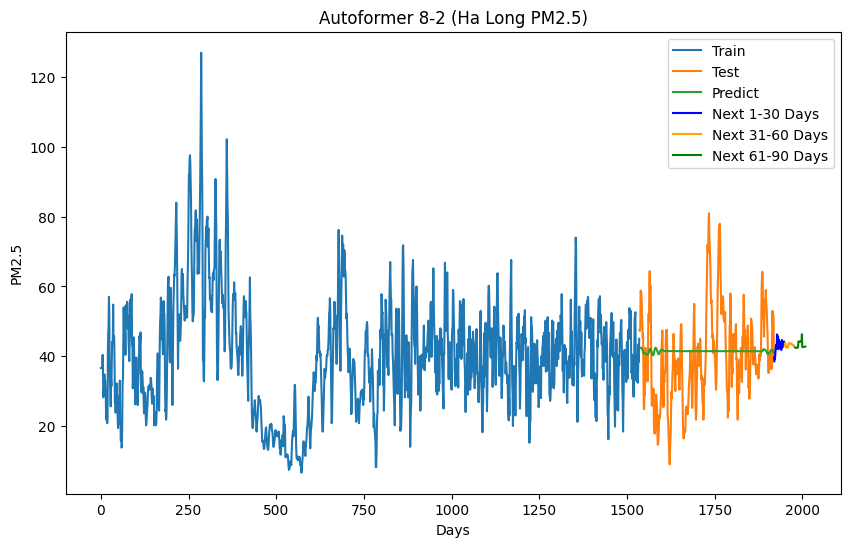

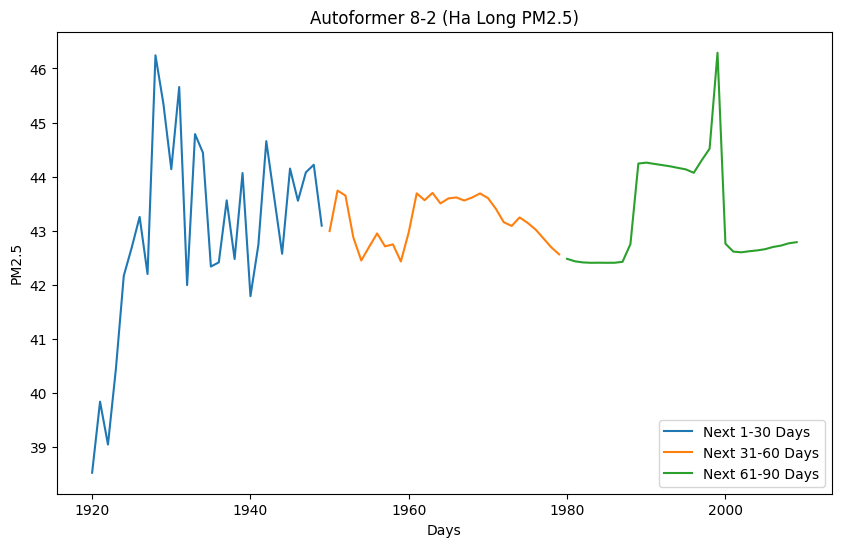

In [16]:
# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['y'], label='Train')
plt.plot(test_data['ds'], test_data['y'], label='Test')
plt.plot(test_data['ds'], y_pred, label='Predict')
plt.plot(np.arange(len(data), len(data) + 30), future_predictions_1_30, color='blue', label='Next 1-30 Days')
plt.plot(np.arange(len(data) + 30, len(data) + 60), future_predictions_31_60, color='orange', label='Next 31-60 Days')
plt.plot(np.arange(len(data) + 60, len(data) + 90), future_predictions_61_90, color='green', label='Next 61-90 Days')
plt.legend()
plt.xlabel('Days')
plt.ylabel('PM2.5')
plt.title('Autoformer 8-2 (Ha Long PM2.5)')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data), len(data) + 30), future_predictions_1_30, color='tab:blue', label='Next 1-30 Days')
plt.plot(np.arange(len(data) + 30, len(data) + 60), future_predictions_31_60, color='tab:orange', label='Next 31-60 Days')
plt.plot(np.arange(len(data) + 60, len(data) + 90), future_predictions_61_90, color='tab:green', label='Next 61-90 Days')
plt.legend()
plt.xlabel('Days')
plt.ylabel('PM2.5')
plt.title('Autoformer 8-2 (Ha Long PM2.5)')
plt.show()